# 3. Topic Modeling
In this notebook we will perform the initial topic modeling of the COVID and Agriculture datasets for the publications track of Hercules project. This phase will consist on the preprocessing of each dataset and the training of several topic models to infer the topics of each corpus.

## Setup

In [1]:
%run __init__.py

In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [3]:
RANDOM_SEED = 42

NOTEBOOK_RESULTS_DIR = os.path.join(RESULTS_DIR, '3_topic_modeling')

## Common functions

Before we start working with our first dataset, we are going a common set of functionality that will be used in both datasets. First of all, we will define a function to print a word cloud based on the given text:

In [4]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt


def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


We also will implement a custom class to perform the preprocessing of texts before they are used by the topic extraction models. This preprocessing will consist of the tokenization of each text, stop word removal and lemmatization. The [Spacy](https://spacy.io) library will be used for this task. Our TextPreprocessor class will allow the use of a custom Spacy model for each different dataset, as we will see later:

In [5]:
import multiprocessing as mp
import string

from joblib import Parallel, delayed
from tqdm.notebook import tqdm

import numpy as np
import spacy

from sklearn.base import TransformerMixin, BaseEstimator
from spacy.util import minibatch


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, spacy_model, additional_stopwords=None, disable=None):
        self.disable = disable if disable is not None else []
        self.custom_stop_words = additional_stopwords if additional_stopwords is not None else []
        self.nlp = spacy_model.load(disable=self.disable)

    def fit(self, X, y=None):
        return self

    def transform(self, X, *args, **kwargs):
        return self._preprocess_docs(X)
    
    def _preprocess_docs(self, X):
        preproc_pipe = []
        for doc in tqdm(self.nlp.pipe(X)):
            preproc_pipe.append(self._get_doc_tokens(doc))
        return preproc_pipe
    
    def _get_doc_tokens(self, doc):
        return [t.lemma_ for t in doc if len(t.text) > 2 and
                not self._is_stop_word(t) and t.text not in string.punctuation
                and t.is_alpha and not t.is_digit]

    def _is_stop_word(self, token):
        return token.is_stop or token.text.lower() in self.custom_stop_words
    

The following function will be used to show the top terms of each topic extracted by a given model:

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


This next set of functions will be use to evaluate our topic extraction models after they have been trained. In the first cell we are making use of the [tmtoolkit](https://tmtoolkit.readthedocs.io/en/latest/) library to obtain the topic coherence of a given model. Specifically, we will be using the _u\_mass_ measure.

The second cell consists of a list of functions to try out several combinations of topics for each given model, and return the model with the best topic coherence amongst them.

In [7]:
import numpy as np

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim


def base_scoring_function(vectorizer, texts, model, X, top_n=20):
    return metric_coherence_gensim(measure='u_mass', dtm=X, 
                                   topic_word_distrib=model.components_,
                                   vocab=np.array([x for x in vectorizer.vocabulary_.keys()]), 
                                   texts=texts, return_mean=True)

In [8]:
MIN_TOPICS = 7
MAX_TOPICS = 30

def try_topics(model_cls, X, scoring_func, **kwargs):
    res = {}
    for num_topics in range(MIN_TOPICS, MAX_TOPICS):
        model = model_cls(n_components=num_topics, random_state=RANDOM_SEED, **kwargs)
        model.fit(X)
        score = scoring_func(model, X)
        res[model] = score
    return res

def print_results_info(model_results):
    best_model = get_best_model(model_results)
    print(f"Best model parameters: {best_model.get_params()}")
    print(f"Topic coherence: {model_results[best_model]}")

def get_best_model(model_results):
    return max(model_results, key=model_results.get)


Finally, we will define a final function to serialize our pipelines so we can load them later on in the following notebooks to obtain the topics of a given piece of text:

In [9]:
import pickle

def save_pipeline(pipeline, output_path):
    with open(output_path, 'wb') as file:
        pickle.dump(pipeline, file)


Now that we have defined our common set of functions, we can start working on each dataset.

## COVID-19

### Loading the dataframe
Since we have already saved a pandas dataframe in the previous notebook, we will begin by loading it:

In [5]:
CORD_DATASET_DIR = os.path.join(DATA_DIR, 'cord19')
CORD19_FILE_PATH = os.path.join(CORD_DATASET_DIR, 'cord19_dataframe.pkl')

cord19_df = pd.read_pickle(CORD19_FILE_PATH)
cord19_df.head()

,id,title,abstract,full_body,authors,references,subjects,text_cleaned,num_chars_text
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,E Cornelissen|H L Dewerchin|E Van Hamme|H J N...,Using direct immunofluorescence to detect coro...,,Feline infectious peritonitis (FIP) is a fatal...,13275
1,00016663c74157a66b4d509d5c4edffd5391bbe0,,,Viruses are increasingly recognised as pathoge...,,Principles of Virology in Fields Virology|Inac...,,Viruses are increasingly recognised as pathoge...,64408
2,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,,How do we protect our 'high-risk' patient popu...,Anastasia Vishnevetsky|Michael Levy,COVID-19)|Prevalence of comorbidities in the n...,,How do we protect our 'high-risk' patient popu...,6243
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...,W K Lam|C K Wong|C W K Lam|A K L Wu|W K Ip|N L...,A major outbreak of severe acute respiratory s...,,Severe acute respiratory syndrome (SARS) is a ...,18655
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,,It is said that crisis reveals character. The ...,Olusola Ajilore|April D Thames,Ethnic Disparities in Hospitalisation for COVI...,,It is said that crisis reveals character. The ...,6829


As we have already seen, some of the articles from this dataset can be really long (aroung $3*10^6$ characters), we will begin by reducing the size of each article to a given threshold. After that, we will remove the cord19 dataframe to save some memory since we won't be using it anymore: 

In [6]:
MAX_ARTICLE_LENGTH = 100000

covid_articles = [article[:MAX_ARTICLE_LENGTH] for article in cord19_df['text_cleaned'].values]
del cord19_df

len(covid_articles)

129982

### Preprocessing text

Now that we have every article to be processed, we can start preprocessing our text. To do that, we will create an instance of the _TextPreprocessor_ class defined above, and pass it the list of texts to be processed:
> This task may take a long time depending on the resources of the machine were it is being run.

In [7]:
import en_core_web_md

custom_stop_words = {"et","al", "introduction", "fig", "figure", "figures" "figs", "abstract"}

covid_preprocessor = TextPreprocessor(en_core_web_md, custom_stop_words, n_jobs=0)
covid_preprocessed = covid_preprocessor.fit_transform(covid_articles)

Since we won't be using the original texts anymore, we can also remove them from memory:

In [8]:
del covid_articles

Before moving to the next steps, we will make a word cloud to examine if there are some interesting terms or singularities about this dataset. It will also help us with making an initial approximation to the dataset and the topics that we may extract:

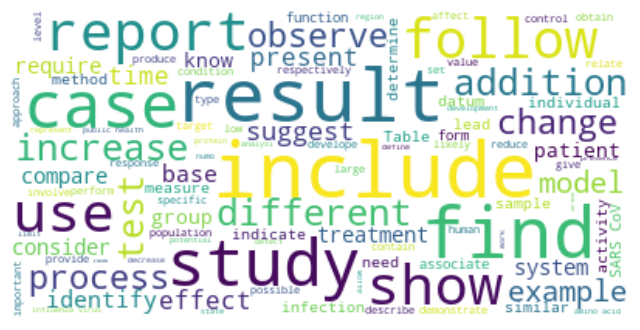

In [15]:
plot_word_cloud(' '.join([' '.join(token) for token in covid_preprocessed[::50]]))

### LDA
We will extract topics for the COVID-19 dataset using the Latent Dirichlet Allocation (LDA) model. In order to use this model, we first need to obtain a term frequency representation of the tokens obtained in the previous section:

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc

covid_tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
covid_dtm_tf = covid_tf_vectorizer.fit_transform(covid_preprocessed)

Now that we have the vector representation of each text, we can train the LDA model:

In [ ]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation

covid_lda = LatentDirichletAllocation(n_components=50, random_state=RANDOM_SEED)
covid_lda.fit(covid_dtm_tf)

In the following cell we will print the term distribution of each topic that has been modelled. For each topic, we will show the top 10 terms:

In [21]:
print_top_words(covid_lda, covid_tf_vectorizer.get_feature_names(), 10)

Topic #0: preprint license medRxiv author copyright grant funder display holder perpetuity
Topic #1: study health participant social group student information experience people high
Topic #2: antibody serum mouse group protein anti IgG PBS day incubate
Topic #3: case datum numb model estimate time rate population report country
Topic #4: cell protein virus infection viral show infect bind membrane result
Topic #5: study patient influenza group pneumonia child infection age year include
Topic #6: patient disease study increase risk level high severe associate report
Topic #7: disease outbreak pandemic epidemic public contact spread health case risk
Topic #8: patient lung pulmonary respiratory day pneumonia disease severe case acute
Topic #9: care use patient system hospital hand include facility staff health
Topic #10: infant woman pregnancy birth rabbit rat pregnant maternal mother study
Topic #11: cat pig PEDV infection sample group study infect piglet positive
Topic #12: health publi

In [ ]:
pyLDAvis.sklearn.prepare(covid_lda, covid_dtm_tf, covid_tf_vectorizer, mds='tsne')

Finally, we are going to serialize our final pipeline so that it can be used in other notebooks to extract the topics of a given text. This pipeline consists of:
* 'preprocessing': Text preprocessing step. A string is given to this transformer, and a list of lemmatized tokens without stop words is returned.
* 'vectorizer': This step will receive the tokens from the text preprocessing and will return a vector form of each document with its term frequency.
* 'model': Finally, the vector input will be given to the LDA model, which will return the probability of the text belonging to each topic.

In [24]:
import pickle

from sklearn.pipeline import Pipeline

covid_lda_pipeline = Pipeline([('preprocessing', covid_preprocessor),
                               ('vectorizer', covid_tf_vectorizer),
                               ('model', covid_lda)])

covid_pipe_filename = "covid_lda_model.pkl"
save_pipeline(covid_lda_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, covid_pipe_filename))

TODO: train model with several different n\_components parameters and analyze results.

In [ ]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation


covid_lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=covid_tf_vectorizer,
                                            texts=covid_preprocessed, model=clf, X=X)


covid_lda_results = try_topics(LatentDirichletAllocation, covid_dtm_tf, covid_lda_scoring_func)
covid_lda_results

In [ ]:
print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

## Agriculture

### Loading the dataframe

In [10]:
AGRICULTURE_DATASET_DIR = os.path.join(DATA_DIR, 'agriculture')
PMC_FILE_PATH = os.path.join(AGRICULTURE_DATASET_DIR, 'pmc_dataframe.pkl')

pmc_df = pd.read_pickle(PMC_FILE_PATH)

### Preprocessing text

In [11]:
publications = pmc_df['text_cleaned'].values[:20]

In [12]:
import en_core_web_sm
import en_core_web_md

import en_core_sci_sm

custom_stop_words = {"et","al", "introduction", "fig", "figure", "figures" "figs", "abstract"}

agriculture_preprocessor = TextPreprocessor(en_core_web_md, custom_stop_words)
preprocessed_texts = agriculture_preprocessor.fit_transform(publications)

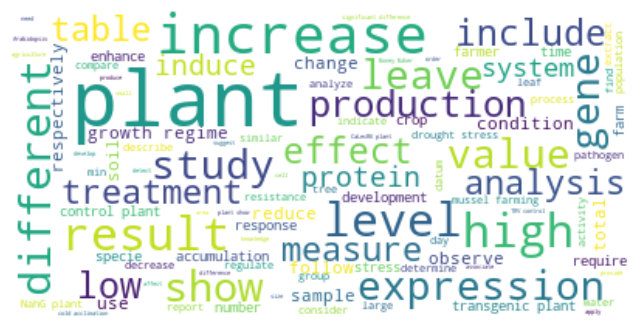

In [13]:
complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

### LDA

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [15]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X)


lda_results = try_topics(LatentDirichletAllocation, dtm_tf, lda_scoring_func)
lda_results

/home/oem/.envs/edma/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


{LatentDirichletAllocation(n_components=7, random_state=42): -1.979230233401039,
 LatentDirichletAllocation(n_components=8, random_state=42): -1.4978123189554786,
 LatentDirichletAllocation(n_components=9, random_state=42): -1.4694568337951,
 LatentDirichletAllocation(random_state=42): -1.410901484103969,
 LatentDirichletAllocation(n_components=11, random_state=42): -1.8788988486099731,
 LatentDirichletAllocation(n_components=12, random_state=42): -2.4558795650163083,
 LatentDirichletAllocation(n_components=13, random_state=42): -1.9173446593665686,
 LatentDirichletAllocation(n_components=14, random_state=42): -2.5435456449046323,
 LatentDirichletAllocation(n_components=15, random_state=42): -2.5141109871749854,
 LatentDirichletAllocation(n_components=16, random_state=42): -4.244584917473961,
 LatentDirichletAllocation(n_components=17, random_state=42): -4.428143619981673,
 LatentDirichletAllocation(n_components=18, random_state=42): -2.9243887757330396,
 LatentDirichletAllocation(n_co

In [83]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show


def get_figure(results,title,line_color):
    n_components = []
    values = []
    for key in results:
        n_components.append(key.n_components)
        values.append(results[key])


    p = figure(
        title=title,
        x_axis_label='n_components',
        y_axis_label='result',
        plot_width=1400, 
        plot_height=400
    )

    p.line(n_components,values,color=line_color,line_width=4)

    return p

def draw_results(results,title,line_color):
    output_notebook()
    show(get_figure(results,title,line_color))
    
draw_results(lda_results,'LDA','green')

Loading BokehJS ...

In [17]:
print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -1.410901484103969


Visualization. Do this with the best model obtained before.

In [18]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: farm farmer food crop empowerment group livestock increase PFA respondent
Topic #1: plant transgenic methanol touch PME insect leave line gene aphid
Topic #2: plant gene expression protein stress CaLecRK population control drought defense
Topic #3: plant NahG stress metal soil tomato TSWV acid CEVd inoculate
Topic #4: mussel cost nutrient abatement farming farm measure target value uncertainty
Topic #5: breeding base system seed food plant orientation crop diversity farmer
Topic #6: growth plant cold Arabidopsis accession regime acclimation temperature LABE Yukon
Topic #7: crop soil till farm farmer increase yield system tillage herbicide
Topic #8: plant dye specie hypertension study use people Bai dyeing informant
Topic #9: plant leaf level mutant development cell Arabidopsis control ROS litura



In [19]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  28.330200
3       0.648955  71.707100       2        1  16.130825
6      71.019684   9.971006       3        1  12.424022
0       3.785981  33.185135       4        1   9.009559
5     -42.666500  -9.222070       5        1   8.084835
8      -3.621689 -43.526516       6        1   6.979584
1      -3.632402  -4.171708       7        1   5.210707
7     -36.584400  35.804413       8        1   4.871681
9      44.391380  50.615383       9        1   4.788241
4      40.235809 -31.591665      10        1   4.170346, topic_info=            Term         Freq        Total Category  logprob  loglift
6806       plant  2342.000000  2342.000000  Default  30.0000  30.0000
3441    breeding   175.000000   175.000000  Default  29.0000  29.0000
8287  transgenic   146.000000   146.000000  Default  28.0000  28.0000
6271      mussel   128.000000   128.000000  Default  27.0000  27.0000
4011        crop   224.000000   224.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
5458    increase    22.111182   375.283132  Topic10  -4.9783   0.3456
2497       Table    15.029310    75.181040  Topic10  -5.3643   1.5673
5261        high    17.389933   341.878427  Topic10  -5.2184   0.1986
4093       datum    15.816184   201.633292  Topic10  -5.3133   0.6318
5928         low    15.029309   181.031283  Topic10  -5.3643   0.6885

[635 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
65        2  0.059996       Africa
65        4  0.119992       Africa
65        6  0.119992       Africa
65        8  0.659957       Africa
72        4  0.814751  Agriculture
...     ...       ...          ...
8681      8  0.267860        yield
8681      9  0.020605        yield
8681     10  0.010302        yield
8696      1  0.035203         μmol
8696      3  0.950474         μmol

[1661 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 7, 1, 6, 9, 2, 8, 10, 5])

In [20]:
from sklearn.pipeline import Pipeline

lda_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lda_model)])

lda_agriculture_pipe_filename = "agriculture_lda_model.pkl"
save_pipeline(lda_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, lda_agriculture_pipe_filename))

#### LDA with bigrams

In [21]:
bigram_tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
bigram_dtm_tf = bigram_tf_vectorizer.fit_transform(preprocessed_texts)


bigram_lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=bigram_tf_vectorizer,
                                                               texts=preprocessed_texts, model=clf, X=X)


bigram_lda_results = try_topics(LatentDirichletAllocation, bigram_dtm_tf, bigram_lda_scoring_func)
bigram_lda_results

{LatentDirichletAllocation(n_components=7, random_state=42): -1.7551909492574194,
 LatentDirichletAllocation(n_components=8, random_state=42): -2.1358770132359535,
 LatentDirichletAllocation(n_components=9, random_state=42): -2.917220005493297,
 LatentDirichletAllocation(random_state=42): -1.5746279401851173,
 LatentDirichletAllocation(n_components=11, random_state=42): -1.9630004441253228,
 LatentDirichletAllocation(n_components=12, random_state=42): -1.622128297401883,
 LatentDirichletAllocation(n_components=13, random_state=42): -1.3478162810664098,
 LatentDirichletAllocation(n_components=14, random_state=42): -2.373638227247187,
 LatentDirichletAllocation(n_components=15, random_state=42): -1.1167575498390707,
 LatentDirichletAllocation(n_components=16, random_state=42): -1.1583568538437208,
 LatentDirichletAllocation(n_components=17, random_state=42): -4.572139039654277,
 LatentDirichletAllocation(n_components=18, random_state=42): -0.7653697900821036,
 LatentDirichletAllocation(n

In [84]:
draw_results(lda_results,'LDA with biagrams','blue')

Loading BokehJS ...

In [22]:
best_bigram_lda_model = get_best_model(bigram_lda_results)

pyLDAvis.sklearn.prepare(best_bigram_lda_model, bigram_dtm_tf, bigram_tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      12.476386  21.314489       1        1  35.802456
5     -52.778774  53.617561       2        1  19.493267
12     18.721022  56.589184       3        1  12.171766
8      46.141033  27.913752       4        1   9.337985
14     22.451477  -7.324051       5        1   6.239518
2     -14.613425  34.742813       6        1   4.652217
11    -41.065746  20.553501       7        1   4.554107
16     32.631145 -47.710770       8        1   4.530496
6      -9.715158 -65.350708       9        1   3.211695
1       3.187571 -30.696495      10        1   0.000722
3     -77.629097 -17.928160      11        1   0.000722
4     -17.986679  68.631378      12        1   0.000722
17    -13.023953  -1.018700      13        1   0.000722
9      55.322254 -11.777896      14        1   0.000722
10    -45.792812  -9.629042      15        1   0.000722
13    -76.011116  20.829033      16        1   0.000722
15    -55.133263 -51.847134      17        1   0.000722
0     -27.017954 -33.631409      18        1   0.000722, topic_info=                      Term         Freq        Total Category  logprob  \
42863                plant  2231.000000  2231.000000  Default  30.0000   
29591               growth   270.000000   270.000000  Default  29.0000   
605            Arabidopsis   160.000000   160.000000  Default  28.0000   
1524               CaLecRK   126.000000   126.000000  Default  27.0000   
16523                 cold   108.000000   108.000000  Default  26.0000   
...                    ...          ...          ...      ...      ...   
20352   decrease tolerance     0.000018     1.322773  Topic18 -11.0203   
20351        decrease time     0.000018     1.053834  Topic18 -11.0203   
20350  decrease supplement     0.000018     1.322773  Topic18 -11.0203   
20376     dedicated fodder     0.000018     1.278557  Topic18 -11.0203   
20378     dedicated legume     0.000018     1.278557  Topic18 -11.0203   

       loglift  
42863  30.0000  
29591  29.0000  
605    28.0000  
1524   27.0000  
16523  26.0000  
...        ...  
20352   0.6445  
20351   0.8718  
20350   0.6445  
20376   0.6785  
20378   0.6785  

[1375 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
38         6  0.924888                  ABTS
71         6  1.019857                   ALP
111        3  0.060249                   ATG
111        4  0.903738                   ATG
113        4  0.990573              ATG gene
...      ...       ...                   ...
61002      4  0.978751           yield plant
61078      4  0.048121                  μmol
61078      7  0.962427                  μmol
61079      7  1.007781           μmol photon
61101      4  0.840413  黄毛青冈 Cyclobalanopsis

[1286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 13, 9, 15, 3, 12, 17, 7, 2, 4, 5, 18, 10, 11, 14, 16, 1])

In [23]:
bigram_lda_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                                ('vectorizer', bigram_tf_vectorizer),
                                ('model', best_bigram_lda_model)])

lda_bigram_agriculture_pipe_filename = "agriculture_bigram_lda_model.pkl"
save_pipeline(lda_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, lda_bigram_agriculture_pipe_filename))

### Latent Semantic Analysis (LSA)

In [24]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = try_topics(TruncatedSVD, dtm_tf, lsa_scoring_func)
lsa_results

{TruncatedSVD(n_components=7, random_state=42): -1.8809021567137822,
 TruncatedSVD(n_components=8, random_state=42): -1.9590457119729114,
 TruncatedSVD(n_components=9, random_state=42): -2.185806838792496,
 TruncatedSVD(n_components=10, random_state=42): -2.0190871827195562,
 TruncatedSVD(n_components=11, random_state=42): -2.433393380984039,
 TruncatedSVD(n_components=12, random_state=42): -2.578071532704827,
 TruncatedSVD(n_components=13, random_state=42): -2.632997699588043,
 TruncatedSVD(n_components=14, random_state=42): -2.883587609313396,
 TruncatedSVD(n_components=15, random_state=42): -3.125895381131332,
 TruncatedSVD(n_components=16, random_state=42): -2.9745146136654896,
 TruncatedSVD(n_components=17, random_state=42): -2.870139984179975,
 TruncatedSVD(n_components=18, random_state=42): -2.746142617687999,
 TruncatedSVD(n_components=19, random_state=42): -2.628466412508861,
 TruncatedSVD(n_components=20, random_state=42): -2.5391197334451556,
 TruncatedSVD(n_components=21, r

In [85]:
draw_results(lsa_results,'LSA','red')

Loading BokehJS ...

In [25]:
print_results_info(lsa_results)
best_lsa_model = get_best_model(lsa_results)

Best model parameters: {'algorithm': 'randomized', 'n_components': 7, 'n_iter': 5, 'random_state': 42, 'tol': 0.0}
Topic coherence: -1.8809021567137822


In [26]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lsa_model, tf_feature_names, 10)

Topic #0: plant growth population expression gene effect high level increase stress
Topic #1: growth cold Arabidopsis accession regime acclimation Yukon Shandong temperature PSII
Topic #2: breeding food crop system base farm farmer seed cost mussel
Topic #3: population herbivore season correct effect damage flower individual edge mixed
Topic #4: mussel cost nutrient abatement farming farm measure target study value
Topic #5: CaLecRK TMV infection gene resistance TRV response control defense expression
Topic #6: NahG TSWV CEVd tomato infect Maker symptom inoculation BTH Money



In [27]:
from sklearn.decomposition import TruncatedSVD

lsa_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lsa_model)])

lsa_agriculture_pipe_filename = "agriculture_lsa_model.pkl"
save_pipeline(lsa_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, lsa_agriculture_pipe_filename))

### NMF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [29]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = try_topics(NMF, dtm_tfidf, nmf_scoring_func, max_iter=300)
nmf_results

{NMF(max_iter=300, n_components=7, random_state=42): -0.6892001805997039,
 NMF(max_iter=300, n_components=8, random_state=42): -0.6920685585905011,
 NMF(max_iter=300, n_components=9, random_state=42): -0.681176481862837,
 NMF(max_iter=300, n_components=10, random_state=42): -0.6633943585766398,
 NMF(max_iter=300, n_components=11, random_state=42): -0.6389525213203434,
 NMF(max_iter=300, n_components=12, random_state=42): -0.6162316781897748,
 NMF(max_iter=300, n_components=13, random_state=42): -0.6725873199735977,
 NMF(max_iter=300, n_components=14, random_state=42): -0.9100864698222021,
 NMF(max_iter=300, n_components=15, random_state=42): -0.7443195708070088,
 NMF(max_iter=300, n_components=16, random_state=42): -0.7265821769919703,
 NMF(max_iter=300, n_components=17, random_state=42): -0.6840202125335778,
 NMF(max_iter=300, n_components=18, random_state=42): -0.7019002744933787,
 NMF(max_iter=300, n_components=19, random_state=42): -0.6809759094056432,
 NMF(max_iter=300, n_componen

In [86]:
draw_results(nmf_results,'MMF','orange')

Loading BokehJS ...

In [30]:
print_results_info(nmf_results)
best_nmf_model = get_best_model(nmf_results)

Best model parameters: {'alpha': 0.0, 'beta_loss': 'frobenius', 'init': None, 'l1_ratio': 0.0, 'max_iter': 300, 'n_components': 26, 'random_state': 42, 'shuffle': False, 'solver': 'cd', 'tol': 0.0001, 'verbose': 0}
Topic coherence: -0.568386845605614


In [31]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

Topic #0: plant high show analysis result datum level significant reduce describe
Topic #1: food crop farmer system increase level security base production farm
Topic #2: plant control gene show expression level compare increase high condition
Topic #3: growth cold accession Arabidopsis regime acclimation temperature Yukon non Shandong
Topic #4: farm livestock PFA crop household ratio income farmer median rice
Topic #5: population herbivore season correct effect damage plant expression flower individual
Topic #6: breeding base seed system orientation plant approach breed require diversity
Topic #7: metal stress fungal formosus toxicity non growth endophytic treat soybean
Topic #8: induce treatment expression min activate gene ROS compound signal compare
Topic #9: stress drought protein gene TRV autophagy water tomato induce increase
Topic #10: LABE bone osteoclast RANKL OVX differentiation cell trap group activity
Topic #11: crop soil till farm farmer increase yield system herbicide ti

In [32]:
nmf_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tfidf_vectorizer),
                         ('model', best_nmf_model)])

nmf_agriculture_pipe_filename = "agriculture_nmf_model.pkl"
save_pipeline(nmf_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, nmf_agriculture_pipe_filename))

### Corex

In [33]:
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt


corex_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, binary=True)
binary_tf = corex_vectorizer.fit_transform(preprocessed_texts)
sparse_binary_tf = ss.csr_matrix(binary_tf)

sparse_binary_tf.shape # n_docs x m_words

(20, 8707)

In [34]:
corex_words = corex_vectorizer.get_feature_names()

corex_model = ct.Corex(n_hidden=40, words=corex_words, max_iter=200, verbose=False, seed=RANDOM_SEED)
corex_model.fit(sparse_binary_tf, words=corex_words)

In [35]:
def print_corex_topics(model):
    corex_topics = model.get_topics()
    for n, topic in enumerate(corex_topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))

print_corex_topics(corex_model)

0: attractive,double,disease,unit,retention,modeling,intensification,costly,externality,mid
1: upper,period,markedly,coincide,successfully,cope,sophisticated,exchange,nitrogen,daily
2: symptom,anti,pellet,overexpression,derivative,silencing,deposit,gain,old,treat
3: primarily,data,simultaneously,design,useful,Biological,custom,trial,male,constitute
4: release,limit,determine,rinse,sustain,pest,barley,bio,trend,resistance
5: feed,account,agricultural,contain,build,larvae,provision,capital,principle,price
6: PCR,primer,depend,commonly,RNA,dna,real,confirm,right,amplification
7: problem,specifically,mediate,literature,essential,determination,conserve,promising,south,conflict
8: specificity,laboratory,pool,fruit,susceptibility,residue,turnover,stimulation,species,colony
9: mention,comprise,reduced,length,University,genomic,isolate,cDNA,survey,Software
10: additionally,molecule,supplement,endogenous,regulation,briefly,body,develop,Agilent,HPLC
11: precipitation,correct,efficiency,radical,re

Visualizing best number of topics

In [36]:
import matplotlib.pyplot as plt

%matplotlib inline

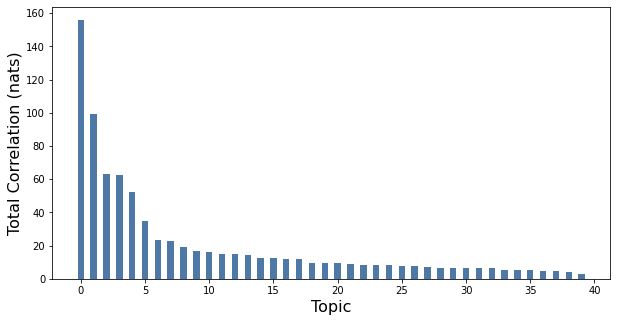

In [37]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_model.tcs.shape[0]), corex_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [38]:
corex_model.tcs

array([155.89896567,  99.19645757,  63.31253513,  62.58411487,
        52.06816461,  34.76563311,  23.53386273,  22.78046214,
        18.91501814,  16.6130986 ,  15.99462699,  15.20416405,
        15.06629788,  14.46313802,  12.79301472,  12.3325991 ,
        11.91100805,  11.76226933,   9.80201412,   9.70948149,
         9.37468643,   8.78465379,   8.46752872,   8.20220091,
         8.11363765,   7.85615592,   7.79215796,   7.09683225,
         6.78964868,   6.72815664,   6.49539203,   6.39133757,
         6.20765832,   5.47350549,   5.16844117,   5.00989982,
         4.96691132,   4.7458077 ,   4.32603811,   2.59468263])

Building the final model

In [39]:
corex_model = ct.Corex(n_hidden=12, words=corex_words, max_iter=200, verbose=False, seed=RANDOM_SEED)
corex_model.fit(sparse_binary_tf, words=corex_words)

In [40]:
print_corex_topics(corex_model)

0: discuss,contribution,service,acid,staining,Methods,cell,interpret,farming,sign
1: chain,correct,oxygen,radical,literature,imaging,downregulate,flavonoid,rich,suppress
2: inoculate,cotton,host,considerable,infect,resolution,paper,activation,pathogen,suspension
3: induction,especially,manufacturer,dissolve,aqueous,wash,statistic,far,hypothesis,irrigation
4: experimental,able,property,store,version,entire,tendency,thickness,trace,mark
5: collect,planting,write,evaluate,deliver,rna,correlation,amount,dynamic,equivalent
6: make,accumulate,generally,carbon,spot,compromise,collection,contact,investigation,type
7: Technologies,season,quantitative,free,mays,threshold,extensive,West,Africa,winter
8: correlate,help,unknown,surface,problem,elicit,comparable,basal,modulate,day
9: transcription,precipitation,regard,frequency,stress,kinase,connect,temporal,green,variance
10: attack,metabolite,seed,Baldwin,distilled,Kim,wounding,relation,cold,issue
11: crucial,chlorophyll,active,room,alternative,da

In [41]:
from corextopic import vis_topic as vt

vt.vis_rep(corex_model, column_label=corex_words)

Print topics in text file


In [87]:
from bokeh.layouts import gridplot

f1 = get_figure(lda_results,'LDA','green')
f2 = get_figure(lda_results,'LDA with biagrams','blue')
f3 = get_figure(lda_results,'LSA','red')
f4 = get_figure(lda_results,'MMF','orange')

# put all the plots in a grid layout
p = gridplot([[f1,f2], [f3, f4]],plot_width=800, plot_height=400)

show(p)